#### The Dataset
###### Packages

In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, f1_score, recall_score, fbeta_score
from sklearn.metrics import precision_recall_curve, auc
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import catboost as cb
import lightgbm as lgb
import optuna
from imblearn.under_sampling import RandomUnderSampler
import optuna.visualization as vis
import numpy as np
import warnings

warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\maria\AppData\Local\Programs\Python\Python312\python.exe


In [2]:
df = pd.read_csv(r"Churn_clean.csv")
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Flag_Contatto_Call_Center,Flag_variazione_Accredito_Stipendio,Num_Punti_Programma_Loyalty,Imp_Liquidit�_Attuale,Imp_Gestito_attuale,Imp_Amministrato_attuale,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,3.0,...,1.0,0.0,NaN,1634.57,2978.40,2980.92,0,0,0,0
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,4.0,...,1.0,-1.0,325.0,11918.26,NaN,34916.15,0,0,0,0
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,4.0,...,1.0,0.0,460.0,2671.95,NaN,232776.62,1,0,0,0
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,2.0,...,0.0,-1.0,NaN,19211.31,15013.53,15017.53,0,0,0,0
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,1.0,NaN,3650.0,1526.38,NaN,NaN,0,0,0,0


In [5]:
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

In [7]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Convert in 0 and 1
XX = pd.get_dummies(X)
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=1, stratify=y)

# Clean the feature names (e.g., remove special characters or spaces)
X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)


#### The Synthetic dataset

In [21]:
synthetic_df = pd.read_csv(r"Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1

X_synthetic = pd.get_dummies(X_synthetic)
X_train_synthetic = clean_feature_names(X_synthetic)

missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  

X_train_res_synthetic = X_train_synthetic[XX.columns]

print("Training features:", X_train_res_synthetic.shape)
print(X_synthetic.shape)


(70000, 276)


#### Parameters
###### n_estimators:  number of trees the model will build. More iterations can lead to better performance but also increase the risk of overfitting.
###### learning_rate: The learning rate controls the contribution of each tree to the final model. A smaller learning rate requires more trees but can lead to better performance by reducing the risk of overfitting.
###### max_depth: maximum tree depth
###### num_leaves: maximum number of leaves
###### min_child_samples: minimum number of observation in a node
###### subsample: The fraction of samples to be used for training each tree. This introduces randomness and can help prevent overfitting.
###### subsample_freq: it indicates after how many iterations it has to remake a new subsample
###### colsample_bytree: The fraction of features to be used for training each tree. Similar to subsample, this introduces randomness and can help prevent overfitting
###### reg_alpha: Lasso
###### reg_lambda: Ridge
###### max_bin: Binning is the process of converting continuous variables into discrete categories. For example, if you have a continuous variable like age, you might bin it into categories such as "0-10", "11-20", "21-30", etc. Each of these categories is called a "bin"
###### force_col_wise: uses histograms to efficiently find the best split points for decision trees during the training process. Histogram-based methods group feature values into discrete bins and then construct histograms based on these bins to find optimal splits
###### scale_pos_weight: for unbalanced train set
###### verbosity: This parameter controls the amount of information LightGBM outputs during training. Setting it to -1 suppresses all warning messages.

#### LightGBM 
###### This alghoritm is the fastest one, so we used this one to evaluate and chose the best metric
#### Rank probabilities
##### Tuning

In [ ]:
def objective(trial):
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.2, random_state=2)
    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    # Align training and testing data based on the inner join of column names
    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    # Calculate the scale_pos_weight parameter for LightGBM
    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    # Define a dictionary containing hyperparameters to optimize
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1,
        'metric':'None'  # Prevents the model from calculating metrics automatically
    }

    # Define stratified k-fold cross-validation
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    # Perform k-fold cross-validation
    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        # Initialize and train LightGBM model with current set of hyperparameters
        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        
        # Predict probabilities on the validation set and select top 10000 indices
        probas = model.predict_proba(X_fold_val)[:, 1]
        top_indices = np.argsort(probas)[-10000:]
        
        # Calculate the ratio of positive samples among the top predictions
        top_positives = y_fold_val.iloc[top_indices].sum()
        total_positives = y_fold_val.sum()
        scores.append(top_positives / total_positives if total_positives > 0 else 0)

    # Return the mean of the scores obtained across all folds
    return np.mean(scores)

# Define a sampler for Optuna to explore the hyperparameter space
sampler = optuna.samplers.TPESampler(seed=42)
# Create a study object for optimization, maximizing the objective function
study = optuna.create_study(direction='maximize', sampler=sampler)
# Optimize the objective function with a specified number of trials
study.optimize(objective, n_trials=50)

# Retrieve the best hyperparameters and the corresponding score
best_params = study.best_params
best_score = study.best_value

# Print out the best hyperparameters and score
print("Best Hyperparameters:", best_params)
print("Best Score for Top 10000:", best_score)


###### 'n_estimators': 270, 'learning_rate': 0.01101265837299383, 'max_depth': 8, 'num_leaves': 35, 'min_child_samples': 46, 'subsample': 0.9576587534894431, 'subsample_freq': 6, 'colsample_bytree': 0.7636004284281295, 'reg_alpha': 0.6189641727169579, 'reg_lambda': 0.34978829279646656, 'max_bin': 300


In [63]:
# Calculate the scale_pos_weight to handle class imbalance by setting it as the ratio of negative to positive samples
scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

# Dictionary to store the best hyperparameters found for the LightGBM classifier
best_params = {
    'n_estimators': 270,  # Number of boosting iterations
    'learning_rate': 0.01101265837299383,  # Learning rate for the boosting process
    'max_depth': 8,  # Maximum depth of the trees
    'num_leaves': 35,  # Maximum number of leaves per tree
    'min_child_samples': 46,  # Minimum number of data points in a leaf node
    'subsample': 0.9576587534894431,  # Fraction of samples to be used for each tree
    'subsample_freq': 6,  # Frequency of subsampling (every n iterations)
    'colsample_bytree': 0.7636004284281295,  # Fraction of features to be used for each tree
    'reg_alpha': 0.6189641727169579,  # L1 regularization term on weights
    'reg_lambda': 0.34978829279646656,  # L2 regularization term on weights
    'max_bin': 300,  # Maximum number of bins for discretizing continuous features
    'force_col_wise': True,  # Force column-wise histogram computation
    'scale_pos_weight': scale_pos_weight,  # Handle class imbalance
    'verbosity': -1  # Set to -1 to suppress warning messages
}

# Build the LightGBM classifier with the chosen hyperparameters
best_lgb_classifier = lgb.LGBMClassifier(**best_params)

# Train the model on the training data
best_lgb_classifier.fit(X_train, y_train)

# Make predictions on the test set and select only the probabilities for the positive class
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]


In [64]:
# Create a DataFrame to store test labels and predicted probabilities
results_df = pd.DataFrame({
    'y_test': y_test,             # Actual labels from the test set
    'y_pred_proba': lgbm_predictions  # Predicted probabilities of being in 'yes' class
})

# Extract top 10,000 samples with the highest predicted probability of being in the 'yes' class
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)  # Sort by predicted probabilities
top_10000_si = results_df_si_sorted.head(10000)  # Select top 10,000 samples with the highest probabilities

# Print the DataFrame containing the top 10,000 samples with the highest predicted probability of staying in 'yes' class
print(top_10000_si)

        y_test  y_pred_proba
8696         1      0.932678
376559       0      0.932280
5785         1      0.930729
58350        1      0.926228
236018       0      0.925851
...        ...           ...
204387       0      0.525024
353535       0      0.524985
257705       0      0.524974
13568        0      0.524914
294074       0      0.524909

[10000 rows x 2 columns]


Number of 'yes' in the top 10,000 predictions: 306
Number of 'yes' in the test set: 397


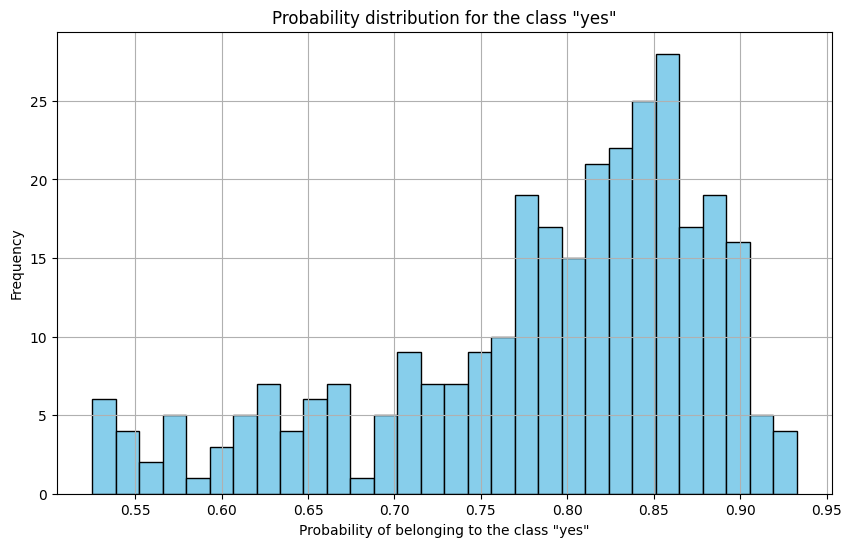

In [65]:
# Count the number of 'yes' labels in the top 10,000 predictions when the true label is 'yes'
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]
print("Number of 'yes' in the top 10,000 predictions:", count_si)

# Count the total number of 'yes' labels in the test set
count_ones = np.sum(y_test == 1)
print("Number of 'yes' in the test set:", count_ones)

# Plot a histogram of the predicted probabilities for the class 'yes' among the top 10,000 predictions
plt.figure(figsize=(10, 6))
plt.hist(top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability of belonging to the class "yes"')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

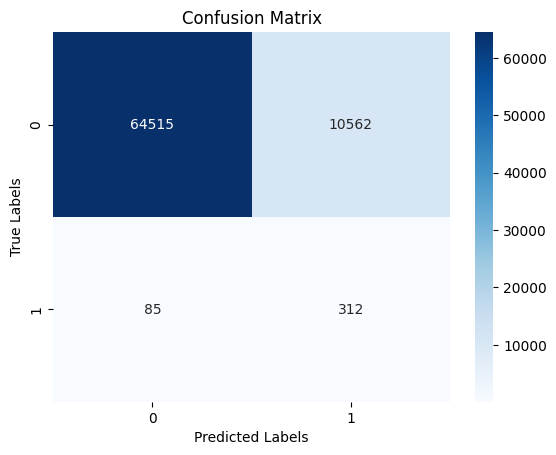

In [66]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


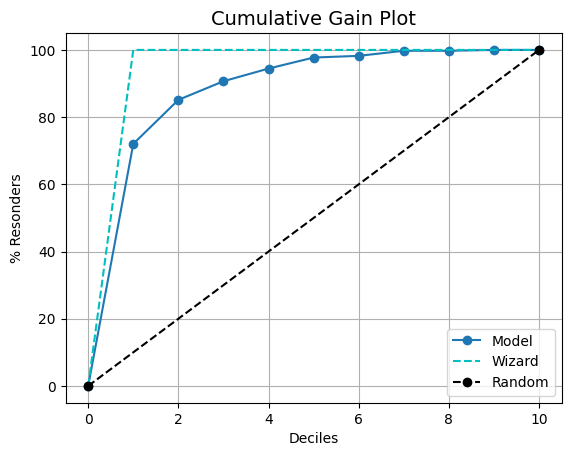

In [68]:
import kds
kds.metrics.plot_cumulative_gain(y_test, lgbm_predictions)

Rank probabilities on the synthetic dataset

Number of 'yes' in the top 10,000 predictions: 322
Number of 'yes' in the test set: 358


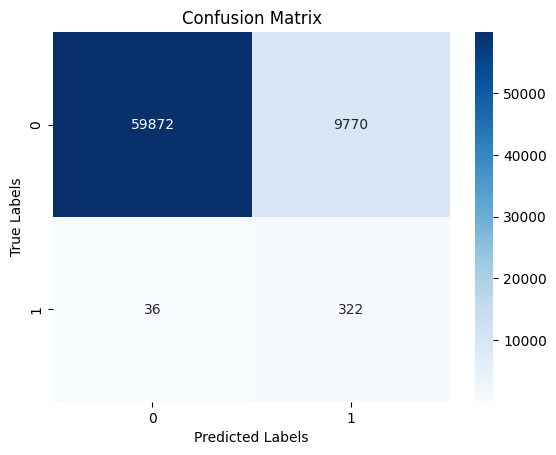

In [69]:
# Make predictions using the best LightGBM classifier on the synthetic training data
lgbm_predictions = best_lgb_classifier.predict_proba(X_synthetic)[:, 1]

# Create a DataFrame to store the true labels and predicted probabilities
results_df = pd.DataFrame({
    'y_test': y_synthetic,  # True labels from the synthetic dataset
    'y_pred_proba': lgbm_predictions  # Predicted probabilities of belonging to class 'yes'
})

# Copy the DataFrame to maintain the original results
results_df_si = results_df

# Sort the DataFrame by predicted probabilities in descending order
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Select the top 10,000 predictions with the highest probabilities
top_100_si = results_df_si_sorted.head(10000)

# Count the number of 'yes' labels among the top 10,000 predictions
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]
print("Number of 'yes' in the top 10,000 predictions:", count_si)

# Count the total number of 'yes' labels in the synthetic test set
count_ones = np.sum(y_synthetic == 1)
print("Number of 'yes' in the test set:", count_ones)

y_pred = best_lgb_classifier.predict(X_synthetic)
cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Metric: Roc Auc

##### Tuning

In [ ]:
def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1,
        'metric':'None' #impedisce di calcolare autonomamente la metrica
            }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]
        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1]  # Get probabilities for the positive class
        #roc auc
        auc = roc_auc_score(y_fold_val, probas)  
        scores.append(auc)

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)



In [71]:
best_params = {
    'n_estimators': 264,
    'learning_rate': 0.011142632664740155,
    'max_depth': 11,
    'num_leaves': 28,
    'min_child_samples': 37,
    'subsample': 0.8024511835587035,
    'subsample_freq': 7,
    'colsample_bytree': 0.883133308624884,
    'reg_alpha': 0.8745173652189913,
    'reg_lambda': 0.9687219187179391,
    'max_bin': 244,
    'force_col_wise': True,
    'verbosity': -1
}
best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [72]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
5785         1      0.890387
91629        0      0.790059
58350        1      0.721934
27245        1      0.619245
17678        1      0.598876
...        ...           ...
345480       0      0.007502
76914        0      0.007501
375842       0      0.007501
67088        0      0.007500
337544       0      0.007499

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 311
Number of 'yes' in the test set 397


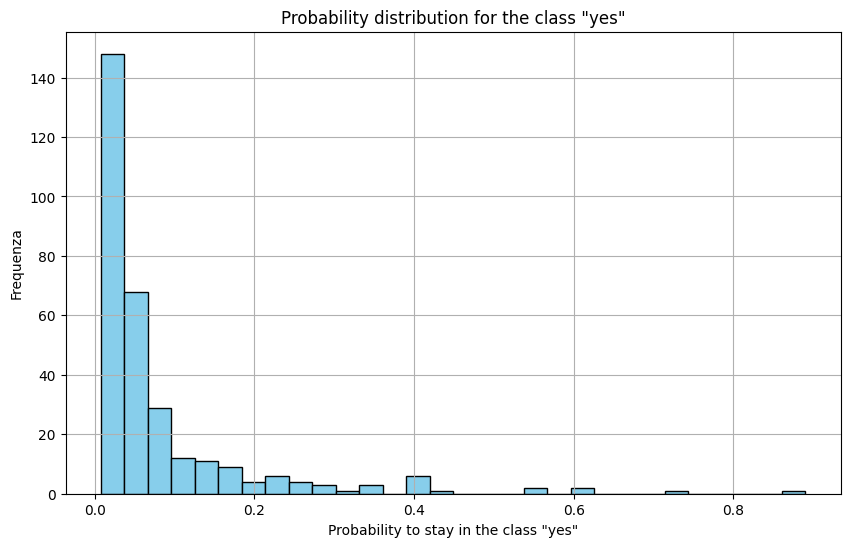

In [27]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]
print("Number of 'yes' in the 10k:", count_si)

count_ones = np.sum(y_test == 1)
print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

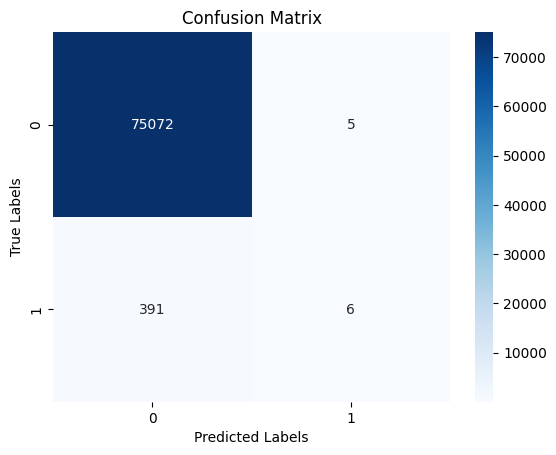

In [28]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

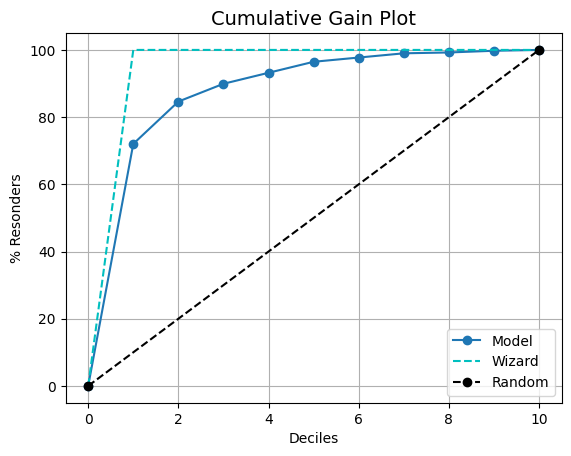

In [73]:
kds.metrics.plot_cumulative_gain(y_test, lgbm_predictions)

Roc Auc on the synthetic dataset

Number of 'yes' in the top 10,000 predictions: 298
Number of 'yes' in the test set: 358


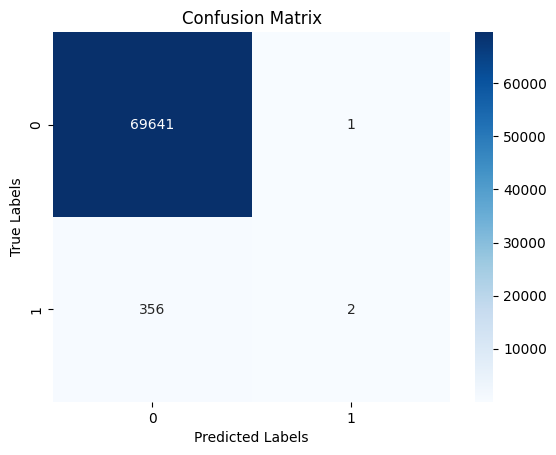

In [29]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

# Copy the DataFrame to maintain the original results
results_df_si = results_df

# Sort the DataFrame by predicted probabilities in descending order
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Select the top 10,000 predictions with the highest probabilities
top_100_si = results_df_si_sorted.head(10000)

# Count the number of 'yes' labels among the top 10,000 predictions
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]
print("Number of 'yes' in the top 10,000 predictions:", count_si)

# Count the total number of 'yes' labels in the synthetic test set
count_ones = np.sum(y_synthetic == 1)
print("Number of 'yes' in the test set:", count_ones)

y_pred = best_lgb_classifier.predict(X_synthetic)
cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Metric:Recall

##### Tuning

In [ ]:
def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1,
        'metric':'None' #impedisce di calcolare autonomamente la metrica
            }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1]  # Get probabilities for the positive class
        preds = (probas > 0.5).astype(int)  # Convert probabilities to binary predictions
        #recall
        recall = recall_score(y_fold_val, preds)
        scores.append(recall)

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)



In [74]:
best_params = {
    'n_estimators': 223,
    'learning_rate': 0.02473710933735549,
    'max_depth': 5,
    'num_leaves': 29,
    'min_child_samples': 28,
    'subsample': 0.9979287455244378,
    'subsample_freq': 5,
    'colsample_bytree': 0.9997861136218631,
    'reg_alpha': 0.9741083680472568,
    'reg_lambda': 0.9792814931859342,
    'max_bin': 240,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  # Ensure that scale_pos_weight is defined in your scope
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [31]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
58350        1      0.988861
5785         1      0.988179
376559       0      0.985295
19464        1      0.982528
27245        1      0.981252
...        ...           ...
73768        0      0.629972
256329       0      0.629822
307017       0      0.629818
261284       0      0.629797
80305        0      0.629797

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 293
Number of 'yes' in the test set 397


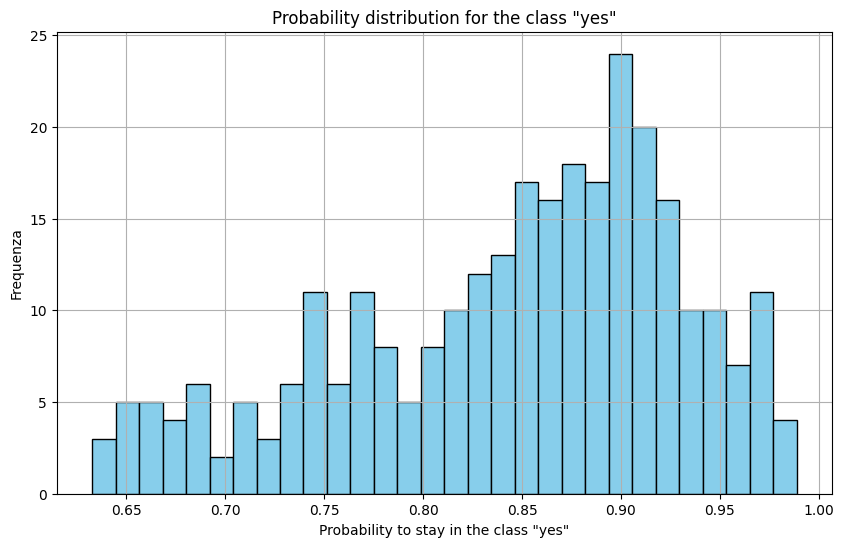

In [32]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

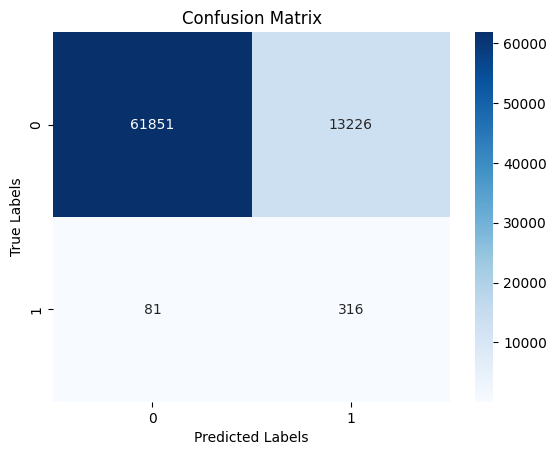

In [33]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

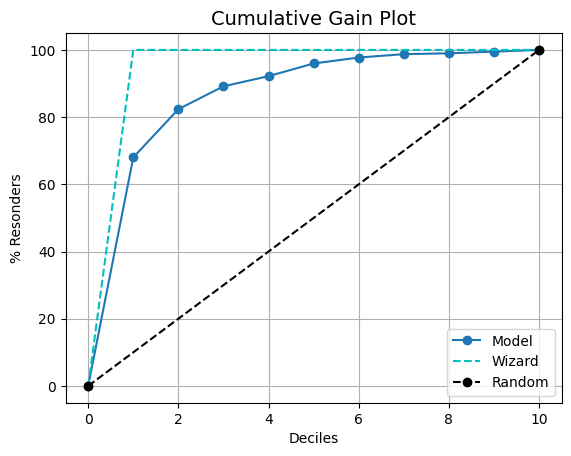

In [75]:
kds.metrics.plot_cumulative_gain(y_test, lgbm_predictions)

Recall on the synthetic dataset

Number of 'yes' in the top 10,000 predictions: 295
Number of 'yes' in the test set: 358


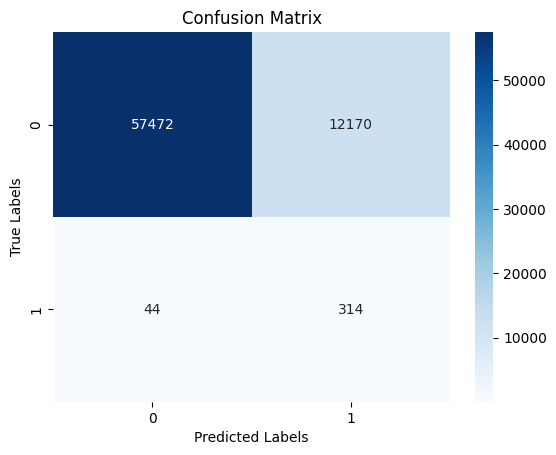

In [34]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_synthetic)[:, 1]
results_df = pd.DataFrame({
    'y_test': y_synthetic,
    'y_pred_proba': lgbm_predictions

})

# Copy the DataFrame to maintain the original results
results_df_si = results_df

# Sort the DataFrame by predicted probabilities in descending order
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Select the top 10,000 predictions with the highest probabilities
top_100_si = results_df_si_sorted.head(10000)

# Count the number of 'yes' labels among the top 10,000 predictions
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]
print("Number of 'yes' in the top 10,000 predictions:", count_si)

# Count the total number of 'yes' labels in the synthetic test set
count_ones = np.sum(y_synthetic == 1)
print("Number of 'yes' in the test set:", count_ones)

y_pred = best_lgb_classifier.predict(X_synthetic)
cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Metric: Precision

##### Tuning

In [ ]:
def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1,
        'metric':'None' #impedisce di calcolare autonomamente la metrica
            }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1]  # Get probabilities for the positive class
        preds = (probas > 0.5).astype(int)  # Convert probabilities to binary predictions
        precision = precision_score(y_fold_val, preds)  # Calcola la precision
        scores.append(precision)

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)

In [39]:
best_params = {
    'n_estimators': 222,
    'learning_rate': 0.0035234408126281255,
    'max_depth': 15,
    'num_leaves': 36,
    'min_child_samples': 50,
    'subsample': 0.8024949185836124,
    'subsample_freq': 1,
    'colsample_bytree': 0.694085486904971,
    'reg_alpha': 0.002310729712339969,
    'reg_lambda': 0.8359805786791278,
    'max_bin': 231,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  # Ensure that scale_pos_weight is defined in your scope
    'verbosity': -1
}


best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [40]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
40767        1      0.560093
5785         1      0.556614
27245        1      0.555189
9195         0      0.551233
376559       0      0.550536
...        ...           ...
57555        0      0.311521
15288        0      0.311479
29095        0      0.311471
199114       0      0.311460
192804       0      0.311412

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 310
Number of 'yes' in the test set 397


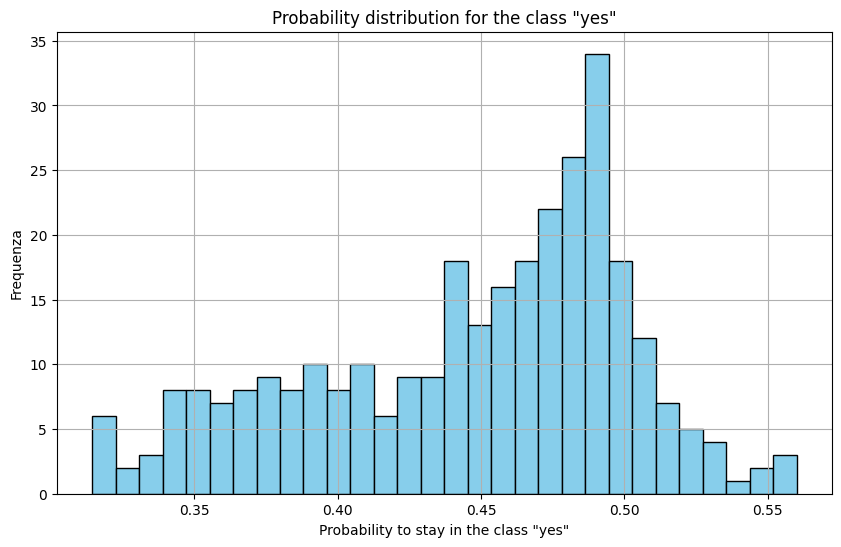

In [41]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

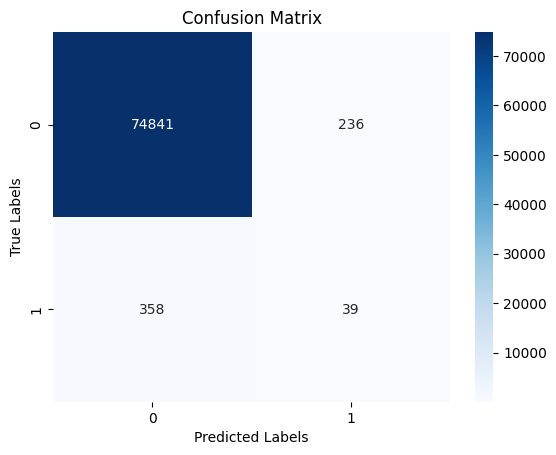

In [42]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


Precision on the synthetic dataset

Number of 'yes' in the top 10,000 predictions: 312
Number of 'yes' in the test set: 358


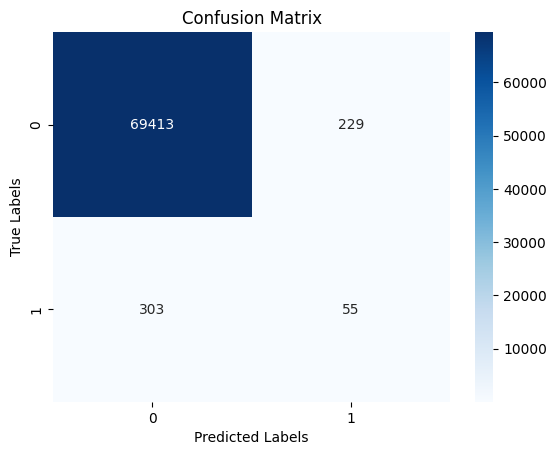

In [44]:
# Make predictions using the best LightGBM classifier on the synthetic training data
lgbm_predictions = best_lgb_classifier.predict_proba(X_synthetic)[:, 1]

# Create a DataFrame to store the true labels and predicted probabilities
results_df = pd.DataFrame({
    'y_test': y_synthetic,  # True labels from the synthetic dataset
    'y_pred_proba': lgbm_predictions  # Predicted probabilities of belonging to class 'yes'
})

# Copy the DataFrame to maintain the original results
results_df_si = results_df

# Sort the DataFrame by predicted probabilities in descending order
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Select the top 10,000 predictions with the highest probabilities
top_100_si = results_df_si_sorted.head(10000)

# Count the number of 'yes' labels among the top 10,000 predictions
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]
print("Number of 'yes' in the top 10,000 predictions:", count_si)

# Count the total number of 'yes' labels in the synthetic test set
count_ones = np.sum(y_synthetic == 1)
print("Number of 'yes' in the test set:", count_ones)

y_pred = best_lgb_classifier.predict(X_synthetic)
cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Metric:F1 score

##### Tuning

In [ ]:
def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1,
        'metric':'None' #impedisce di calcolare autonomamente la metrica
            }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1]  # Get probabilities for the positive class
        preds = (probas > 0.5).astype(int)  # Convert probabilities to binary predictions
        f1 = f1_score(y_fold_val, preds)  # Calcola F1 score
        scores.append(f1)

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)

In [45]:
best_params = {
    'n_estimators': 114,
    'learning_rate': 0.006680983417211186,
    'max_depth': 6,
    'num_leaves': 38,
    'min_child_samples': 35,
    'subsample': 0.8661796049705299,
    'subsample_freq': 0,
    'colsample_bytree': 0.7243929286862649,
    'reg_alpha': 0.32518332202674705,
    'reg_lambda': 0.7296061783380641,
    'max_bin': 264,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight, 
    'verbosity': -1
}
best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [46]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
5785         1      0.579325
27245        1      0.568718
376559       0      0.560393
58350        1      0.557303
349867       0      0.552723
...        ...           ...
56572        0      0.313126
324449       0      0.313115
265407       0      0.313111
183790       0      0.313111
172316       0      0.313084

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 302
Number of 'yes' in the test set 397


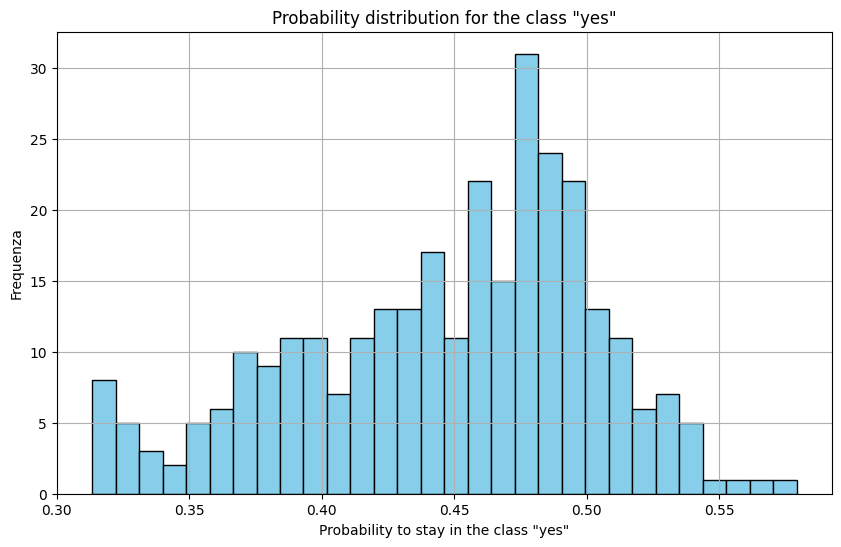

In [47]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

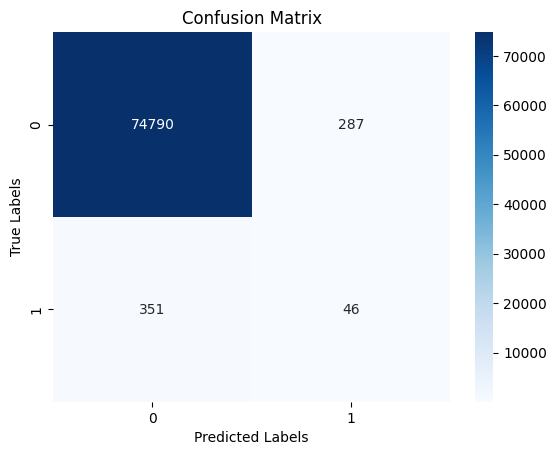

In [48]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

F1 on the synthetic dataset

Number of 'yes' in the top 10,000 predictions: 304
Number of 'yes' in the test set: 358


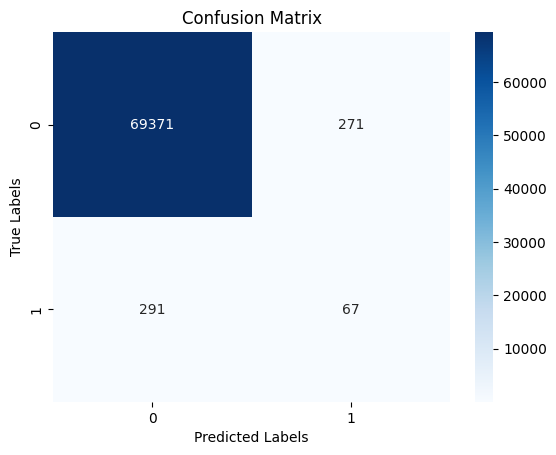

In [49]:
# Make predictions using the best LightGBM classifier on the synthetic training data
lgbm_predictions = best_lgb_classifier.predict_proba(X_synthetic)[:, 1]

# Create a DataFrame to store the true labels and predicted probabilities
results_df = pd.DataFrame({
    'y_test': y_synthetic,  # True labels from the synthetic dataset
    'y_pred_proba': lgbm_predictions  # Predicted probabilities of belonging to class 'yes'
})

# Copy the DataFrame to maintain the original results
results_df_si = results_df

# Sort the DataFrame by predicted probabilities in descending order
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Select the top 10,000 predictions with the highest probabilities
top_100_si = results_df_si_sorted.head(10000)

# Count the number of 'yes' labels among the top 10,000 predictions
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]
print("Number of 'yes' in the top 10,000 predictions:", count_si)

# Count the total number of 'yes' labels in the synthetic test set
count_ones = np.sum(y_synthetic == 1)
print("Number of 'yes' in the test set:", count_ones)

y_pred = best_lgb_classifier.predict(X_synthetic)
cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### Metric:F2 beta

##### Tuning

In [ ]:
def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'scale_pos_weight': scale_pos_weight, 
        'force_col_wise': True,
        'verbosity': -1,
        'metric':'None' #impedisce di calcolare autonomamente la metrica
            }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        probas = model.predict_proba(X_fold_val)[:, 1]  # Get probabilities for the positive class
        preds = (probas > 0.5).astype(int)  # Convert probabilities to binary predictions
        f2 = fbeta_score(y_fold_val, preds, beta=2)  # Calcola F2 score
        scores.append(f2)

    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_score = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Score for Top 50,000:", best_score)

In [58]:
best_params = {
    'n_estimators': 223,
    'learning_rate': 0.0038506136777269,
    'max_depth': 15,
    'num_leaves': 31,
    'min_child_samples': 49,
    'subsample': 0.9616132068894329,
    'subsample_freq': 6,
    'colsample_bytree': 0.6113887387854107,
    'reg_alpha': 0.0200533381277905,
    'reg_lambda': 0.4152066163632999,
    'max_bin': 233,
    'force_col_wise': True,
    'scale_pos_weight': scale_pos_weight,  
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

In [59]:
results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
171230       0      0.591174
49952        0      0.583616
376559       0      0.581977
5785         1      0.579597
27245        1      0.576637
...        ...           ...
247993       0      0.338017
176377       0      0.338009
354958       0      0.337987
218157       0      0.337987
20568        0      0.337979

[10000 rows x 2 columns]


Number of 'yes' in the 10k: 308
Number of 'yes' in the test set 397


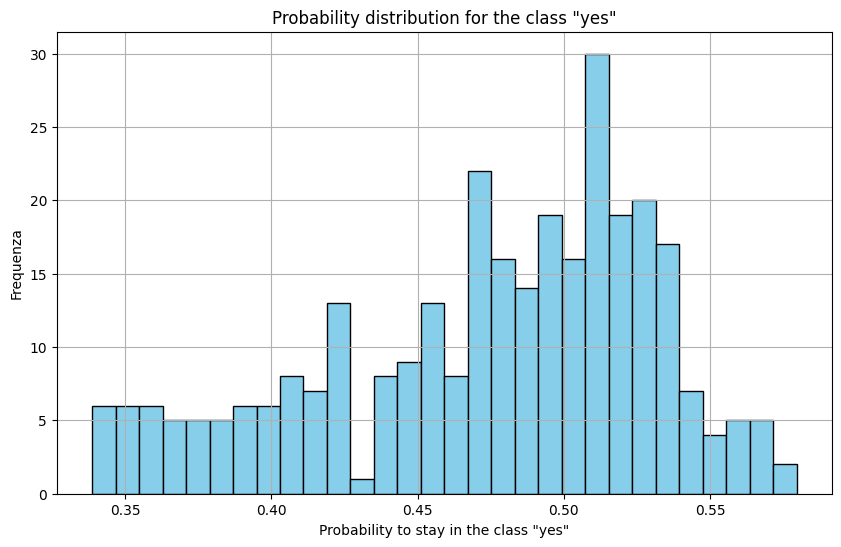

In [60]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Number of 'yes' in the 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Number of 'yes' in the test set", count_ones)

plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Probability distribution for the class "yes"')
plt.xlabel('Probability to stay in the class "yes"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

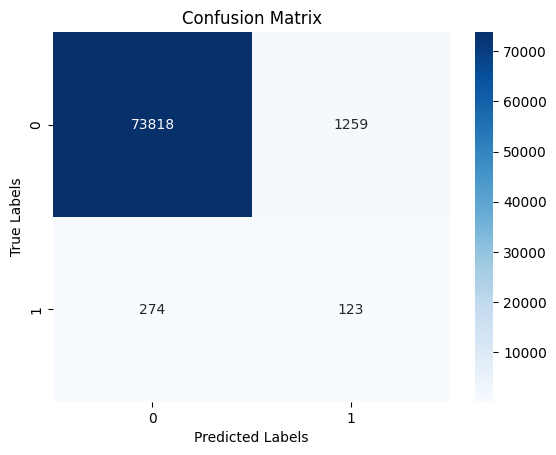

In [61]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


F2 on the synthetic dataset

Number of 'yes' in the top 10,000 predictions: 309
Number of 'yes' in the test set: 358


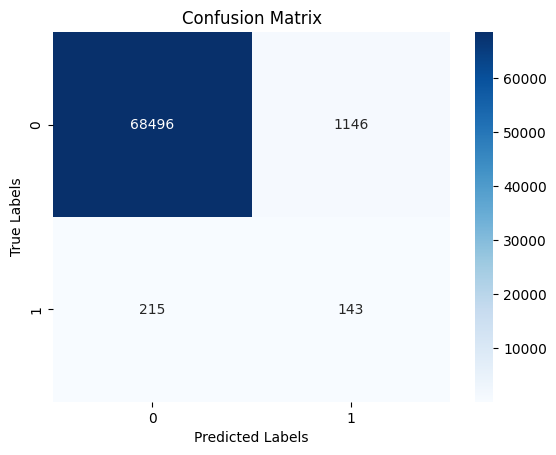

In [62]:
# Make predictions using the best LightGBM classifier on the synthetic training data
lgbm_predictions = best_lgb_classifier.predict_proba(X_synthetic)[:, 1]

# Create a DataFrame to store the true labels and predicted probabilities
results_df = pd.DataFrame({
    'y_test': y_synthetic,  # True labels from the synthetic dataset
    'y_pred_proba': lgbm_predictions  # Predicted probabilities of belonging to class 'yes'
})

# Copy the DataFrame to maintain the original results
results_df_si = results_df

# Sort the DataFrame by predicted probabilities in descending order
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)

# Select the top 10,000 predictions with the highest probabilities
top_100_si = results_df_si_sorted.head(10000)

# Count the number of 'yes' labels among the top 10,000 predictions
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]
print("Number of 'yes' in the top 10,000 predictions:", count_si)

# Count the total number of 'yes' labels in the synthetic test set
count_ones = np.sum(y_synthetic == 1)
print("Number of 'yes' in the test set:", count_ones)

y_pred = best_lgb_classifier.predict(X_synthetic)
cm = confusion_matrix(y_synthetic, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


##### Original dataset:
##### -Rank probabilities: Numero di 'si' 306/397, FN=85
##### -Roc Auc: Numero di 'si' 311/397,  FN=391
##### -Recall: Numero di 'si' 293/397, FN=81
##### -Precision: Numero di 'si' 310/397, FN=358
##### -F1: Numero di 'si' 302/397, FN=351
##### -F2: Numero di 'si' 308/397, FN=274

##### synthetic dataset:
##### -Rank probabilities: Numero di 'si' 322/358, FN=36
##### -Roc Auc: Numero di 'si' 298/358, FN=356
##### -Recall: Numero di 'si' 295/358, FN=44
##### -Precision: Numero di 'si' 312/358, FN=303
##### -F1: Numero di 'si' 304/358, FN=291
##### -F2: Numero di 'si' 309/358, FN=215

##### Recall e Rank probabilities are the best, following the cumulative gain curve we chose the rank probabilities